In [1]:
%run Prepare_Python.ipynb

## 0. Basic usage

There are two required arguments:

- the first argument is expected to be a dataframe with both group indicator variables and covariates,
- the second argument specifies a list with names of column which indicate the group membership.

Additional arguments can be provided, such as `name` (specifies `xlab()` for intersection matrix) or `width_ratio` (specifies how much space should be occupied by the set size panel). Other such arguments are discussed at length later in this document.

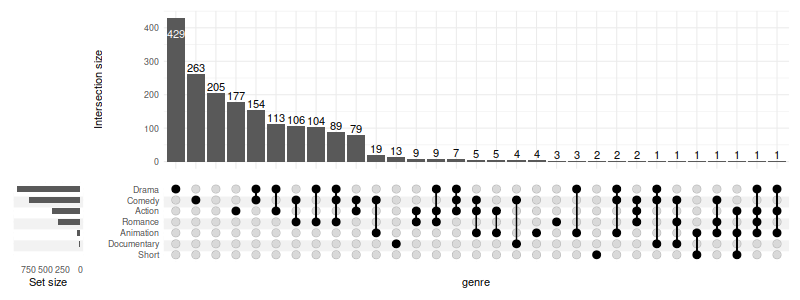

In [2]:
%%R -w 800 -h 300
upset(movies, genres, name='genre', width_ratio=0.1)

### 0.1 Selecting intersections

We will focus on the intersections with at least ten members `(min_size=10)` and on a few variables which are significantly different between the intersections (see 2. Running statistical tests).

When using `min_size`, the empty groups will be skipped by default (e.g. *Short* movies would have no overlap with size of 10). To keep all groups pass `keep_empty_groups=TRUE`:

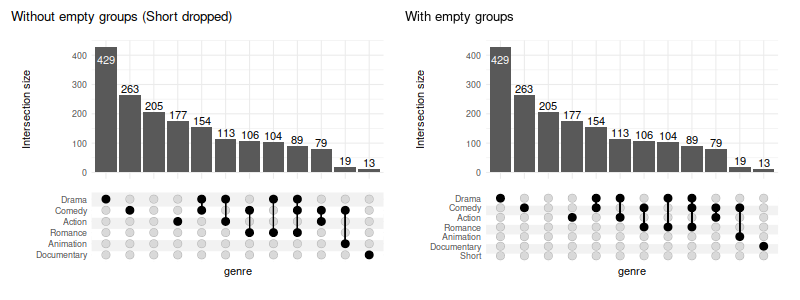

In [3]:
%%R -w 800 -h 300
(
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, wrap=TRUE, set_sizes=FALSE)
    + ggtitle('Without empty groups (Short dropped)')
    +    # adding plots is possible thanks to patchwork
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, keep_empty_groups=TRUE, wrap=TRUE, set_sizes=FALSE)
    + ggtitle('With empty groups')
)

When empty columns are detected a warning will be issued. The silence it, pass `warn_when_dropping_groups=FALSE`. Complimentary `max_size` can be used in tandem.

You can also select intersections by degree (`min_degree` and `max_degree`):

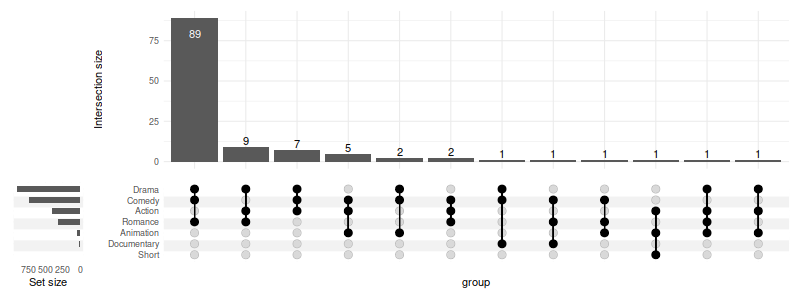

In [4]:
%%R -w 800 -h 300
upset(
    movies, genres, width_ratio=0.1,
    min_degree=3,
)

Or request a constant number of intersections with `n_intersections`:

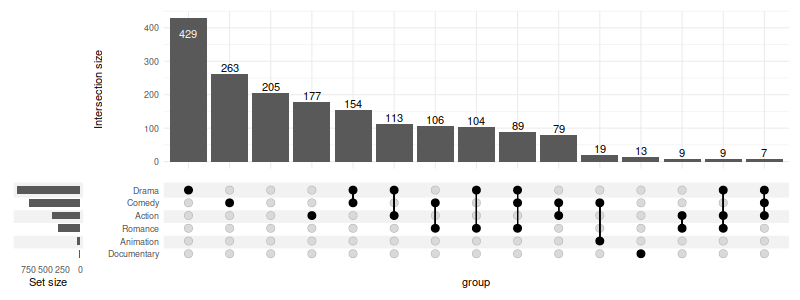

In [5]:
%%R -w 800 -h 300
upset(
    movies, genres, width_ratio=0.1,
    n_intersections=15
)

### 0.2 Region selection modes

There are four modes defining the regions of interest on corresponding Venn diagram:

- `exclusive_intersection` region: intersection elements that belong to the sets defining the intersection but not to any other set (alias: *distinct*), **default**
- `inclusive_intersection` region: intersection elements that belong to the sets defining the intersection including overlaps with other sets (alias: *intersect*)
- `exclusive_union` region: union elements that belong to the sets defining the union, *excluding* those overlapping with any other set
- `inclusive_union` region: union elements that belong to the sets defining the union, *including* those overlapping with any other set (alias: *union*)

Example: given three sets $A$, $B$ and $C$ with number of elements defined by the Venn diagram below

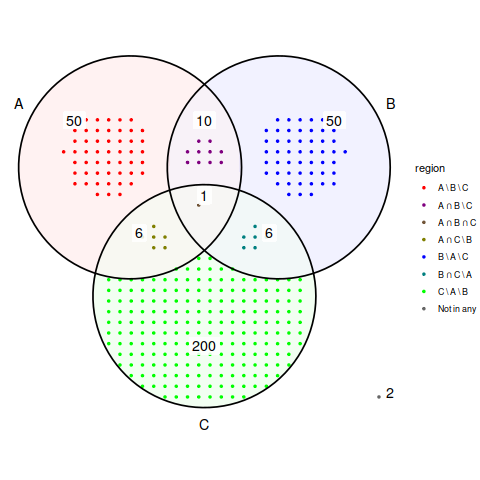

In [6]:
%%R
abc_data = create_upset_abc_example()

abc_venn = (
    ggplot(arrange_venn(abc_data))
    + coord_fixed()
    + theme_void()
    + scale_color_venn_mix(abc_data)
)

(
    abc_venn
    + geom_venn_region(data=abc_data, alpha=0.05)
    + geom_point(aes(x=x, y=y, color=region), size=1)
    + geom_venn_circle(abc_data)
    + geom_venn_label_set(abc_data, aes(label=region))
    + geom_venn_label_region(
        abc_data, aes(label=size),
        outwards_adjust=1.75,
        position=position_nudge(y=0.2)
    )
    + scale_fill_venn_mix(abc_data, guide='none')
)

For the above sets $A$ and $B$ the region selection modes correspond to region of Venn diagram defined as follows:

- exclusive intersection: $(A \cap B) \setminus C$
- inclusive intersection: $A \cap B$
- exclusive union: $(A \cup B) \setminus C$
- inclusive union: $A \cup B$

and have the total number of elements as in the table below:

| members \ mode   | exclusive int. | inclusive int. | exclusive union | inclusive union |
|------------------|----------|-----------|------------------|-----------------|
| (A, B)           | 10       | 11        | 110              | 123             |
| (A, C) == (B, C) | 6        | 7         | 256              | 273             |
| (A) == (B)       | 50       | 67        | 50               | 67              |
| (C)              | 200      | 213       | 200              | 213             |
| (A, B, C)        | 1        | 1         | 323              | 323             |
| ()               | 2        | 2         | 2                | 2               |

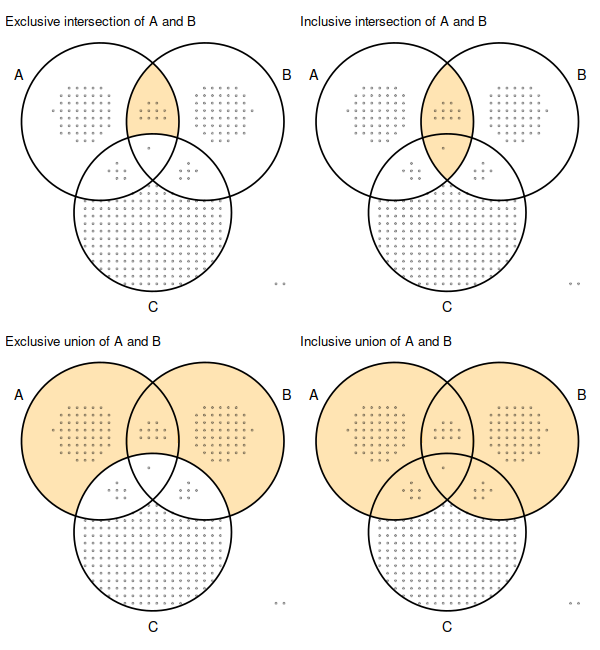

In [7]:
%%R -w 600 -h 650
simple_venn = (
    abc_venn
    + geom_venn_region(data=abc_data, alpha=0.3)
    + geom_point(aes(x=x, y=y), size=0.75, alpha=0.3)
    + geom_venn_circle(abc_data)
    + geom_venn_label_set(abc_data, aes(label=region), outwards_adjust=2.55)
)
highlight = function(regions) scale_fill_venn_mix(
    abc_data, guide='none', highlight=regions, inactive_color='NA'
)

(
    (
        simple_venn + highlight(c('A-B')) + labs(title='Exclusive intersection of A and B')
        | simple_venn + highlight(c('A-B', 'A-B-C')) + labs(title='Inclusive intersection of A and B')
    ) /
    (
        simple_venn + highlight(c('A-B', 'A', 'B')) + labs(title='Exclusive union of A and B')
        | simple_venn + highlight(c('A-B', 'A-B-C', 'A', 'B', 'A-C', 'B-C')) + labs(title='Inclusive union of A and B')
    )
)

When customizing the `intersection_size()` it is important to adjust the mode accordingly, as it defaults to `exclusive_intersection` and cannot be automatically deduced when user customizations are being applied:

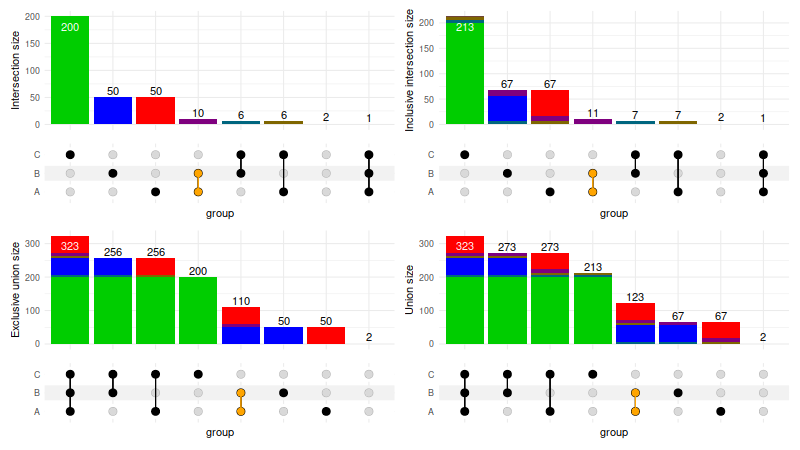

In [8]:
%%R -w 800 -h 450
abc_upset = function(mode) upset(
    abc_data, c('A', 'B', 'C'), mode=mode, set_sizes=FALSE,
    encode_sets=FALSE,
    queries=list(upset_query(intersect=c('A', 'B'), color='orange')),
    base_annotations=list(
        'Size'=(
            intersection_size(
                mode=mode,
                mapping=aes(fill=exclusive_intersection),
                size=0,
                text=list(check_overlap=TRUE)
            ) + scale_fill_venn_mix(
                data=abc_data,
                guide='none',
                colors=c('A'='red', 'B'='blue', 'C'='green3')
            )
        )
    )
)

(
    (abc_upset('exclusive_intersection') | abc_upset('inclusive_intersection'))
    /
    (abc_upset('exclusive_union') | abc_upset('inclusive_union'))
)

### 0.3 Displaying all intersections

To display all possible intersections (rather than only the observed ones) use `intersections='all'`.

**Note 1**: it is usually desired to filter all the possible intersections down with `max_degree` and/or `min_degree` to avoid generating all combinations as those can easily use up all available RAM memory when dealing with multiple sets (e.g. all human genes) due to sheer number of possible combinations

**Note 2**: using `intersections='all'` is only reasonable for mode different from the default *exclusive intersection*.

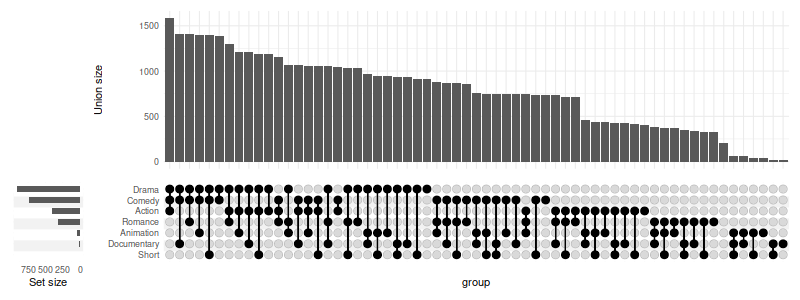

In [9]:
%%R -w 800 -h 300
upset(
    movies, genres,
    width_ratio=0.1,
    min_size=10,
    mode='inclusive_union',
    base_annotations=list('Size'=(intersection_size(counts=FALSE, mode='inclusive_union'))),
    intersections='all',
    max_degree=3
)

## 1. Adding components

We can add multiple annotation components (also called panels) using one of the three methods demonstrated below:

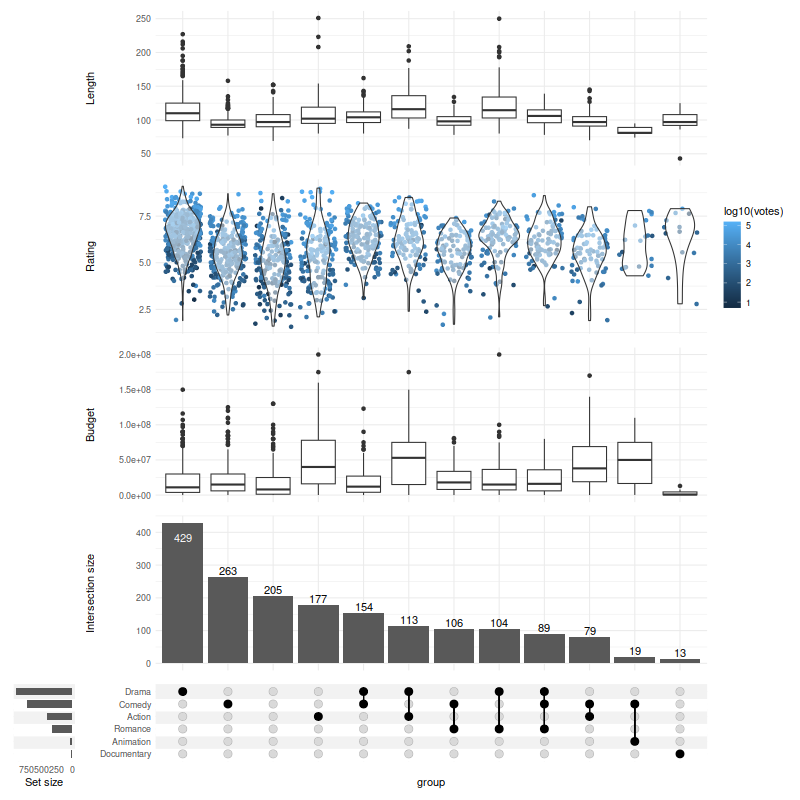

In [10]:
%%R -w 800 -h 800

set.seed(0)   # keep the same jitter for identical plots

upset(
    movies,
    genres,
    annotations = list(
        # 1st method - passing list:
        'Length'=list(
            aes=aes(x=intersection, y=length),
            # provide a list if you wish to add several geoms
            geom=geom_boxplot(na.rm=TRUE)
        ),
        # 2nd method - using ggplot
        'Rating'=(
            # note that aes(x=intersection) is supplied by default and can be skipped
            ggplot(mapping=aes(y=rating))
            # checkout ggbeeswarm::geom_quasirandom for better results!
            + geom_jitter(aes(color=log10(votes)), na.rm=TRUE)
            + geom_violin(alpha=0.5, na.rm=TRUE)
        ),
        # 3rd method - using `upset_annotate` shorthand
        'Budget'=upset_annotate('budget', geom_boxplot(na.rm=TRUE))
    ),
    min_size=10,
    width_ratio=0.1
)

You can also use barplots to demonstrate differences in proportions of categorical variables:

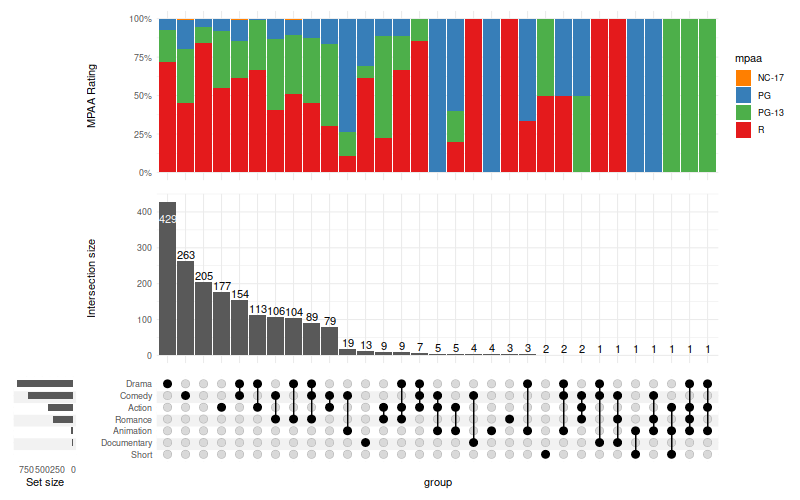

In [11]:
%%R -w 800 -h 500

upset(
    movies,
    genres,
    annotations = list(
        'MPAA Rating'=(
            ggplot(mapping=aes(fill=mpaa))
            + geom_bar(stat='count', position='fill')
            + scale_y_continuous(labels=scales::percent_format())
            + scale_fill_manual(values=c(
                'R'='#E41A1C', 'PG'='#377EB8',
                'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
            ))
            + ylab('MPAA Rating')
        )
    ),
    width_ratio=0.1
)

### 1.1. Changing modes in annotations

Use `upset_mode` to change the mode of the annotation:

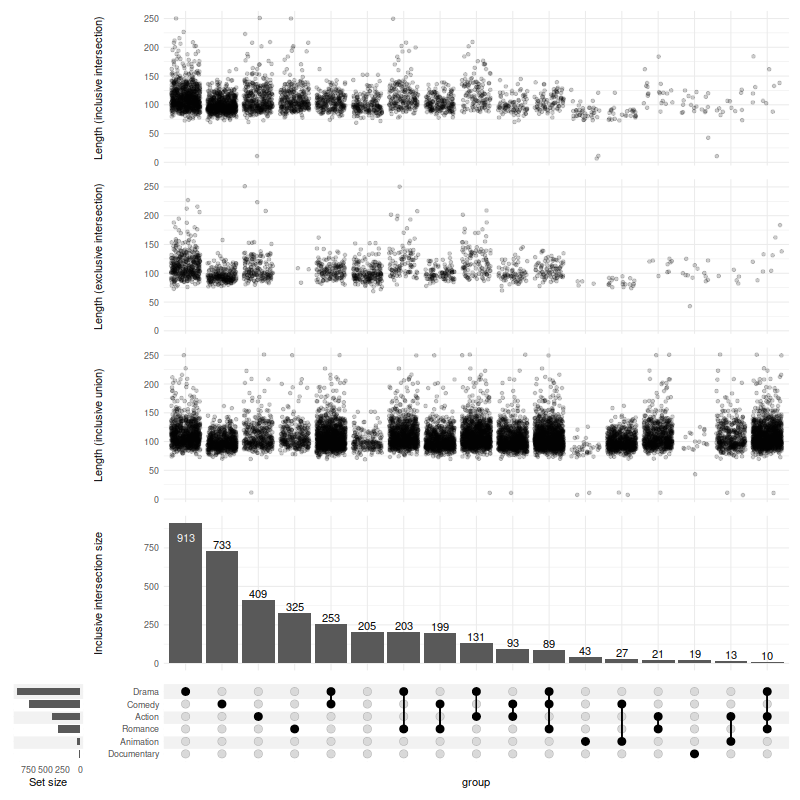

In [12]:
%%R -w 800 -h 800
set.seed(0)
upset(
    movies,
    genres,
    mode='inclusive_intersection',
    annotations = list(
        # if not specified, the mode will follow the mode set in `upset()` call (here: `inclusive_intersection`)
        'Length (inclusive intersection)'=(
            ggplot(mapping=aes(y=length))
            + geom_jitter(alpha=0.2, na.rm=TRUE)
        ),
        'Length (exclusive intersection)'=(
            ggplot(mapping=aes(y=length))
            + geom_jitter(alpha=0.2, na.rm=TRUE)
            + upset_mode('exclusive_intersection')
        ),
        'Length (inclusive union)'=(
            ggplot(mapping=aes(y=length))
            + geom_jitter(alpha=0.2, na.rm=TRUE)
            + upset_mode('inclusive_union')
        )
    ),
    min_size=10,
    width_ratio=0.1
)

## 2. Running statistical tests

In [13]:
%R upset_test(movies, genres)

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,1.027673e-45
budget,budget,3.899860e-44,288.974760,Kruskal-Wallis rank sum test,2.209921e-43
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,4.207502e-38
mpaa,mpaa,3.732200e-35,242.779393,Kruskal-Wallis rank sum test,1.268948e-34
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30
r1,r1,2.211600e-23,180.327398,Kruskal-Wallis rank sum test,5.371029e-23
r4,r4,1.008119e-18,154.627715,Kruskal-Wallis rank sum test,2.142254e-18
r3,r3,2.568227e-17,146.702174,Kruskal-Wallis rank sum test,4.851095e-17
r5,r5,9.823827e-16,137.663096,Kruskal-Wallis rank sum test,1.670051e-15


`Kruskal-Wallis rank sum test` is not always the best choice.

You can either change the test for:

 - all the variables (`test=your.test`), or
 - specific variables (using `tests=list(variable=some.test)` argument)

The tests are called with `(formula=variable ~ intersection, data)` signature, such as accepted by `kruskal.test`. The result is expected to be a list with following members:

- `p.value`
- `statistic`
- `method`

It is easy to adapt tests which do not obey this signature/output convention; for example the Chi-squared test and anova can be wrapped with two-line functions as follows:

In [14]:
%%R
chisq_from_formula = function(formula, data) {
    chisq.test(
        ftable(formula, data)
    )
}

anova_single = function(formula, data) {
    result = summary(aov(formula, data))
    list(
        p.value=result[[1]][['Pr(>F)']][[1]],
        method='Analysis of variance Pr(>F)',
        statistic=result[[1]][['F value']][[1]]
    )
}

custom_tests = list(
    mpaa=chisq_from_formula,
    budget=anova_single
)

In [15]:
%R head(upset_test(movies, genres, tests=custom_tests))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
budget,budget,1.348209e-60,13.663948,Analysis of variance Pr(>F),1.145977e-59
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,6.851151e-46
mpaa,mpaa,9.799097e-42,406.338139,Pearson's Chi-squared test,4.164616e-41
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,3.366002e-38
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30


Many tests will require at least two observations in each group. You can skip intersections with less than two members with `min_size=2`.

In [16]:
%%R
bartlett_results = suppressWarnings(upset_test(movies, genres, test=bartlett.test, min_size=2))
tail(bartlett_results)

[1] "NA, year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, NA differ significantly between intersections"
       variable      p.value statistic
year       year 1.041955e-67 386.53699
length   length 3.982729e-67 383.70148
budget   budget 7.637563e-50 298.89911
rating   rating 3.980194e-06  66.63277
title     title           NA        NA
mpaa       mpaa           NA        NA
                                            test          fdr
year   Bartlett test of homogeneity of variances 1.302444e-67
length Bartlett test of homogeneity of variances 4.595457e-67
budget Bartlett test of homogeneity of variances 8.183103e-50
rating Bartlett test of homogeneity of variances 3.980194e-06
title  Bartlett test of homogeneity of variances           NA
mpaa   Bartlett test of homogeneity of variances           NA


### 2.1 Ignore specific variables

You may want to exclude variables which are:

 - highly correlated and therefore interfering with the FDR calculation, or
 - simply irrelevant

In the movies example, the title variable is not a reasonable thing to compare. We can ignore it using:

In [17]:
%%R
# note: title no longer present
rownames(upset_test(movies, genres, ignore=c('title')))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"
 [1] "length" "rating" "budget" "r8"     "mpaa"   "r9"     "r1"     "r4"    
 [9] "r3"     "r5"     "r7"     "r2"     "r10"    "votes"  "r6"     "year"  


## 3. Adjusting "Intersection size"

### 3.1 Counts

The counts over the bars can be disabled:

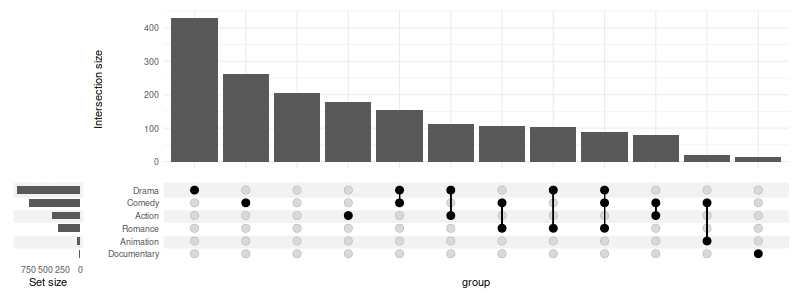

In [18]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(counts=FALSE)
    ),
    min_size=10,
    width_ratio=0.1
)

The colors can be changed, and additional annotations added:

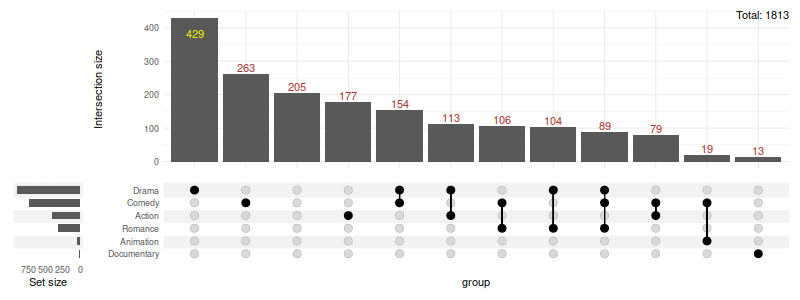

In [19]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_colors=c(
                on_background='brown', on_bar='yellow'
            )
        )
        + annotate(
            geom='text', x=Inf, y=Inf,
            label=paste('Total:', nrow(movies)),
            vjust=1, hjust=1
        )
        + ylab('Intersection size')
    ),
    min_size=10,
    width_ratio=0.1
)

Any parameter supported by `geom_text` can be passed in `text` list:

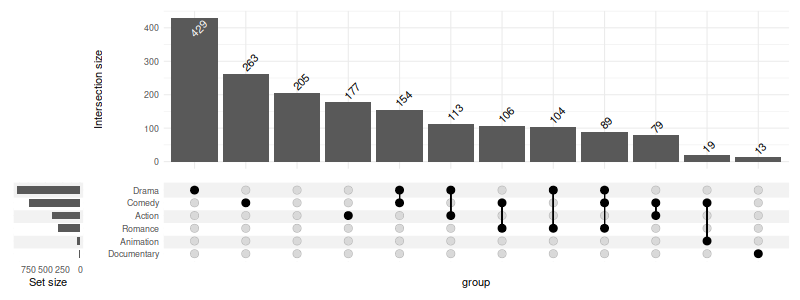

In [20]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(
                vjust=-0.1,
                hjust=-0.1,
                angle=45
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

### 3.2 Fill the bars

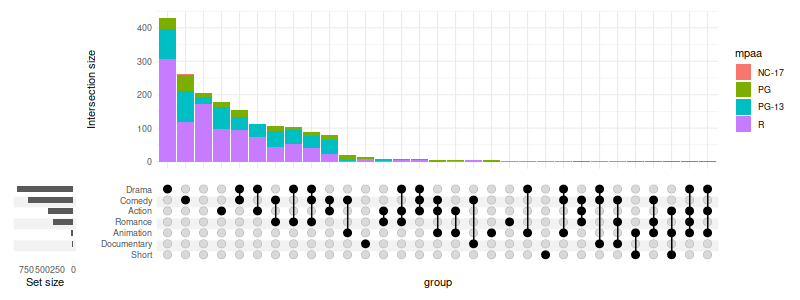

In [21]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            mapping=aes(fill=mpaa)
        )
    ),
    width_ratio=0.1
)

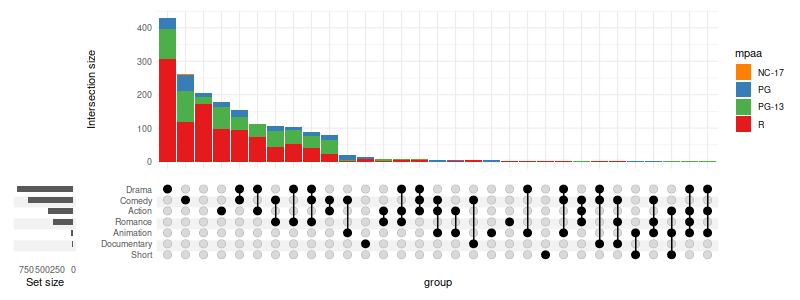

In [22]:
%%R -w 800 -h 300
upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            mapping=aes(fill=mpaa)
        ) + scale_fill_manual(values=c(
            'R'='#E41A1C', 'PG'='#377EB8',
            'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
        ))
    ),
    width_ratio=0.1
)

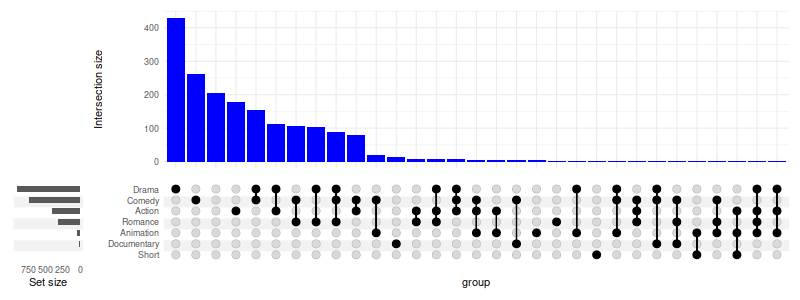

In [23]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            mapping=aes(fill='bars_color')
        ) + scale_fill_manual(values=c('bars_color'='blue'), guide='none')
    ),
    width_ratio=0.1
)

### 3.3 Adjusting the height ratio

Setting `height_ratio=1` will cause the intersection matrix and the intersection size to have an equal height:

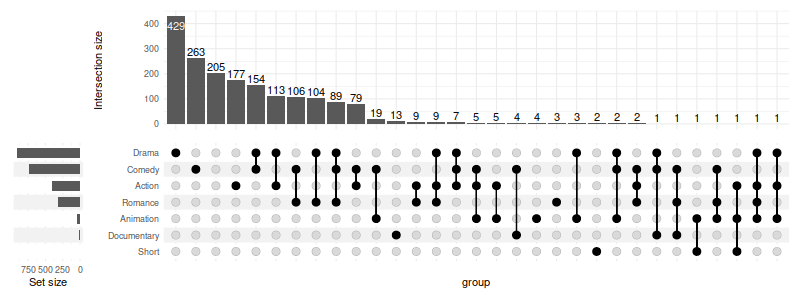

In [24]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    height_ratio=1,
    width_ratio=0.1
)

### 3.5 Hiding intersection size

You can always disable the intersection size altogether:

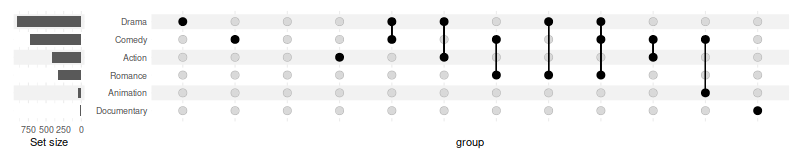

In [25]:
%%R -w 800 -h 160
upset(
    movies,
    genres,
    base_annotations=list(),
    min_size=10,
    width_ratio=0.1
)

### 3.6 Showing intersection size/union size ratio

It can be useful to visualise which intersections are larger than expected by chance (assuming equal probability of belonging to multiple sets); this can be achieved using the intersection size/union size ratio.

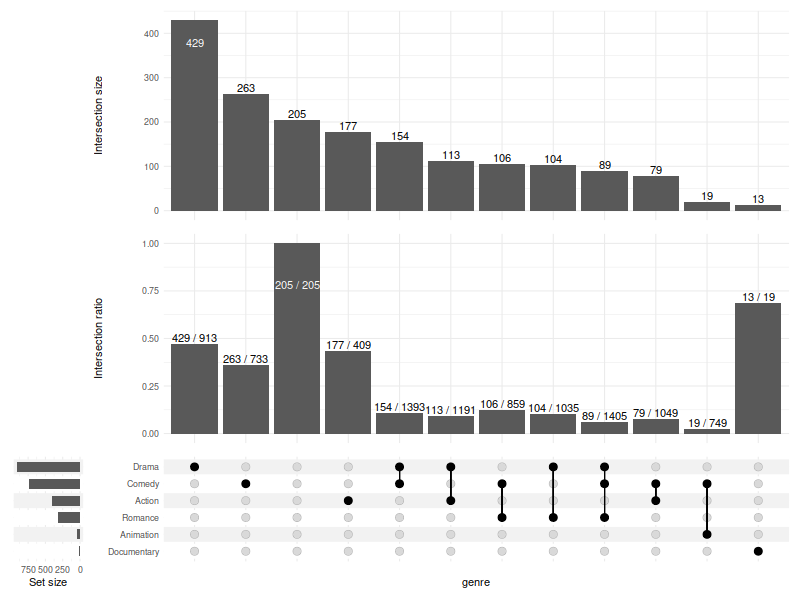

In [26]:
%%R -w 800 -h 600
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        'Intersection size'=intersection_size(),
        'Intersection ratio'=intersection_ratio()
    )
)

The plot above tells us that the analysed documentary movies are almost always (in over 60% of cases) documentaries (and nothing more!), while comedies more often include elements of other genres (e.g. drama, romance) rather than being comedies alone (like stand-up shows).

### 3.7 Showing percentages

`text_mapping` can be used to manipulate the aesthetics of the labels. Using the `intersection_size` and `union_size` one can calculate percentage of items in the intersection (relative to the potential size of the intersection). A `upset_text_percentage(digits=0, sep='')` shorthand is provided for convenience:

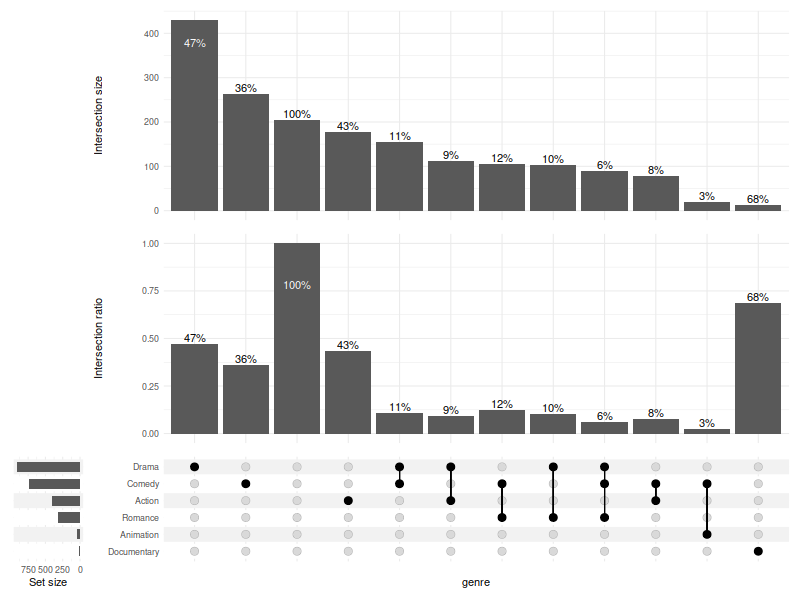

In [27]:
%%R -w 800 -h 600
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        # with manual aes specification:
        'Intersection size'=intersection_size(text_mapping=aes(label=paste0(round(
            !!get_size_mode('exclusive_intersection')/!!get_size_mode('inclusive_union') * 100
        ), '%'))),
        # using shorthand:
        'Intersection ratio'=intersection_ratio(text_mapping=aes(label=!!upset_text_percentage()))
    )
)

Also see [10. Display percentages](#10-display-percentages).

#### 3.7.1 Showing percentages and numbers together

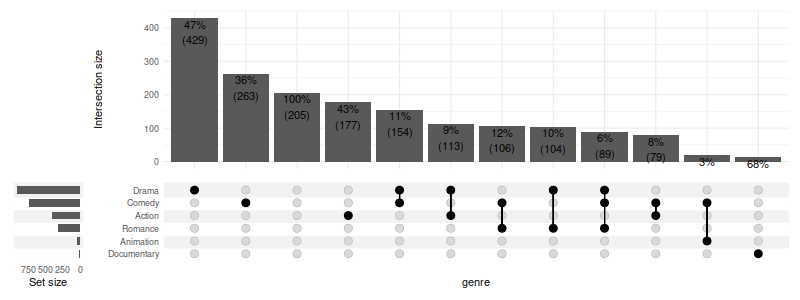

In [28]:
%%R -w 800 -h 300
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_mapping=aes(label=paste0(
                !!upset_text_percentage(),
                '\n',
                '(',
                !!get_size_mode('exclusive_intersection'),
                ')'
            )),
            bar_number_threshold=1,
            text=list(vjust=1.1)
        )
    )
)

#### 3.8 Custom positioning on bars/background

If adjusting `bar_number_threshold` is not sufficient, you can specify custom rules for placement of text on bars/background:

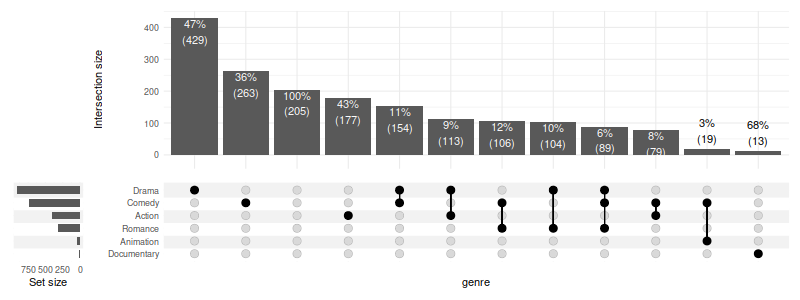

In [29]:
%%R -w 800 -h 300
size = get_size_mode('exclusive_intersection')
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_mapping=aes(
                label=paste0(
                    !!upset_text_percentage(),
                    '\n(', !!size, ')'
                ),
                colour=ifelse(!!size > 50, 'on_bar', 'on_background'),
                y=ifelse(!!size > 50, !!size - 100, !!size)
            )
        )
    )
)

### 3.8 Further adjustments using ggplot2 functions

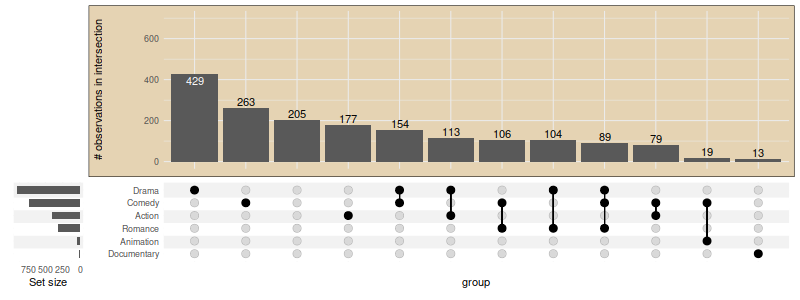

In [30]:
%%R  -w 800 -h 300
upset(
    movies, genres, width_ratio=0.1,
    base_annotations = list(
        'Intersection size'=(
            intersection_size()
            + ylim(c(0, 700))
            + theme(plot.background=element_rect(fill='#E5D3B3'))
            + ylab('# observations in intersection')
        )
    ),
    min_size=10
)

## 4. Adjusting "set size"

When using thresholding or selection criteria (such as `min_size` or `n_intersections`) the change in number of elements in each set size is not reflected in the set sizes plot by default. You can change this by providing `filter_intersections=TRUE` to `upset_set_size`.

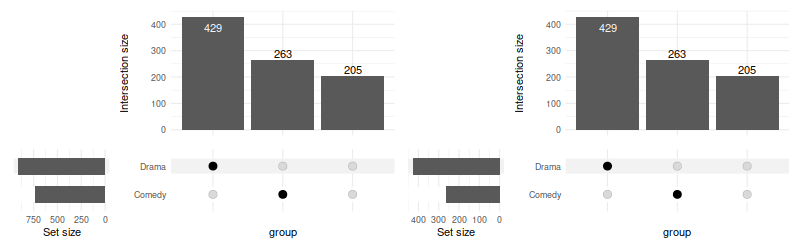

In [31]:
%%R -w 800 -h 250
upset(
    movies, genres,
    min_size=200,
    set_sizes=upset_set_size()
) | upset(
    movies, genres,
    min_size=200,
    set_sizes=upset_set_size(filter_intersections=TRUE)
)

### 4.1 Rotate labels

To rotate the labels modify corresponding theme:

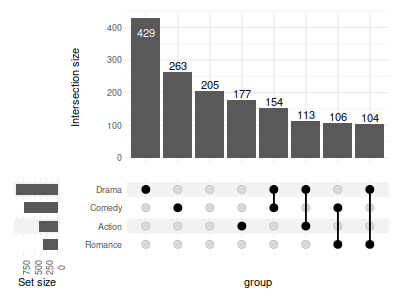

In [32]:
%%R -w 400 -h 300
upset(
    movies, genres,
    min_size=100,
    width_ratio=0.15,
    set_sizes=(
        upset_set_size()
        + theme(axis.text.x=element_text(angle=90))
    )
)

To display the ticks:

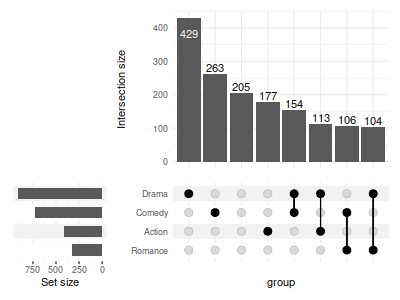

In [33]:
%%R -w 400 -h 300
upset(
    movies, genres, width_ratio=0.3, min_size=100,
    set_sizes=(
        upset_set_size()
        + theme(axis.ticks.x=element_line())
    )
)

### 4.2 Modify geoms and other layers

Arguments of the `geom_bar` can be adjusted in `upset_set_size`; it can use a different geom, or be replaced with a custom list of layers altogether:

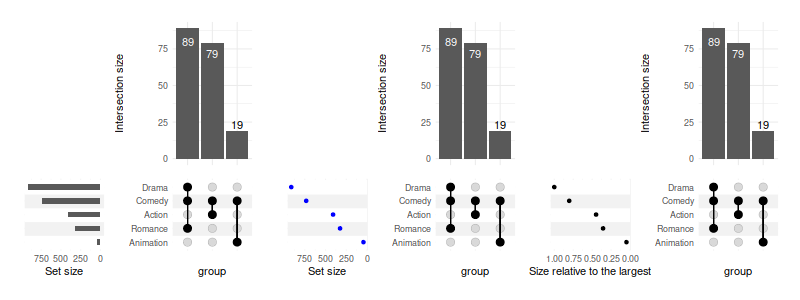

In [34]:
%%R -w 800 -h 300

(
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=upset_set_size(
            geom=geom_bar(width=0.4)
        )
    )
    +
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=upset_set_size(
            geom=geom_point(
                stat='count',
                color='blue'
            )
        )
    )
    +
    upset(
        movies, genres, width_ratio=0.5, max_size=100, min_size=15, wrap=TRUE,
        set_sizes=(
            upset_set_size(
                geom=geom_point(stat='count'),
                mapping=aes(y=..count../max(..count..)),
            )
            + ylab('Size relative to the largest')
        )
    )
)

### 4.3 Logarithmic scale

In order to use a log scale we need to pass additional scale to in `layers` argument. However, as the bars are on flipped coordinates, we need a reversed log transformation. Appropriate function, `reverse_log_trans()` is provided:

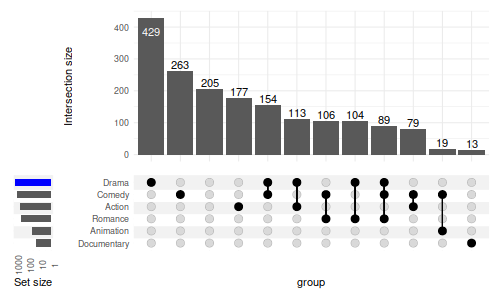

In [35]:
%%R -w 500 -h 300

upset(
    movies, genres,
    width_ratio=0.1,
    min_size=10,
    set_sizes=(
        upset_set_size()
        + theme(axis.text.x=element_text(angle=90))
        + scale_y_continuous(trans=reverse_log_trans())
    ),
    queries=list(upset_query(set='Drama', fill='blue'))
)

We can also modify the labels to display the logged values:

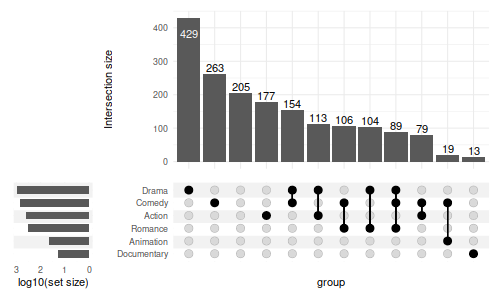

In [36]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    width_ratio=0.2,
    set_sizes=upset_set_size()
        + scale_y_continuous(
            trans=reverse_log_trans(),
            labels=log10
        )
        + ylab('log10(set size)')
)

### 4.4 Display counts

To display the count add `geom_text()`:

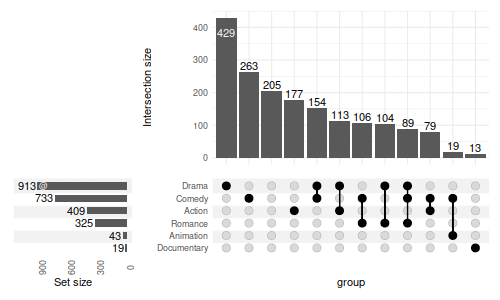

In [37]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    width_ratio=0.3,
    encode_sets=FALSE,  # for annotate() to select the set by name disable encoding
    set_sizes=(
        upset_set_size()
        + geom_text(aes(label=..count..), hjust=1.1, stat='count')
        # you can also add annotations on top of bars:
        + annotate(geom='text', label='@', x='Drama', y=850, color='white', size=3)
        + expand_limits(y=1100)
        + theme(axis.text.x=element_text(angle=90))
    )
)

### 4.5 Change position and add fill

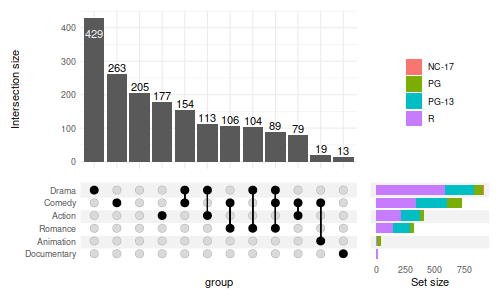

In [38]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    width_ratio=0.3,
    set_sizes=(
        upset_set_size(
            geom=geom_bar(
                aes(fill=mpaa, x=group),
                width=0.8
            ),
            position='right'
        )
    ),
    # moves legends over the set sizes
    guides='over'
)

### 4.6 Hide the set sizes altogether

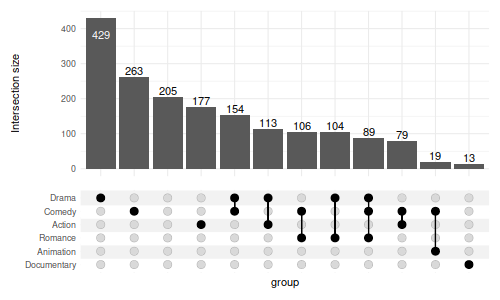

In [39]:
%%R -w 500 -h 300

upset(
    movies, genres,
    min_size=10,
    set_sizes=FALSE
)

### 4.7 Change the label

For compatibility with older `ggplot2` versions, `upset_set_size` generates a plot with flipped coordinates and therefore `ylab` needs to be used instead of `xlab` (and aesthetic `x` is used in examples above in place of `y`. This wil change it in a future major release of `ComplexUpset`.

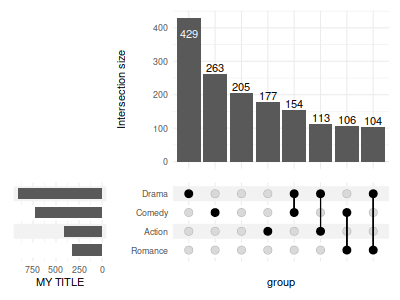

In [40]:
%%R -w 400 -h 300
upset(
    movies, genres, width_ratio=0.3, min_size=100,
    set_sizes=(
        upset_set_size()
        + ylab('MY TITLE')
    )
)

## 5. Adjusting other aesthetics

### 5.1 Stripes

Change the colors:

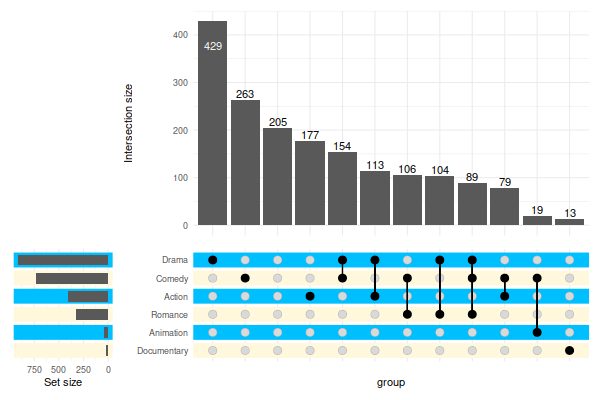

In [41]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=c('cornsilk1', 'deepskyblue1')
)

You can use multiple colors:

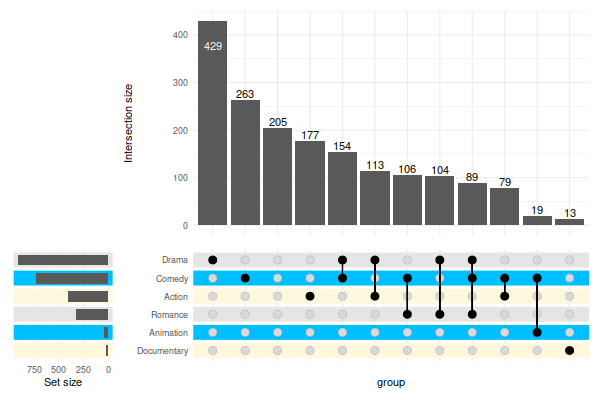

In [42]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=c('cornsilk1', 'deepskyblue1', 'grey90')
)

Or, set the color to white to effectively disable the stripes:

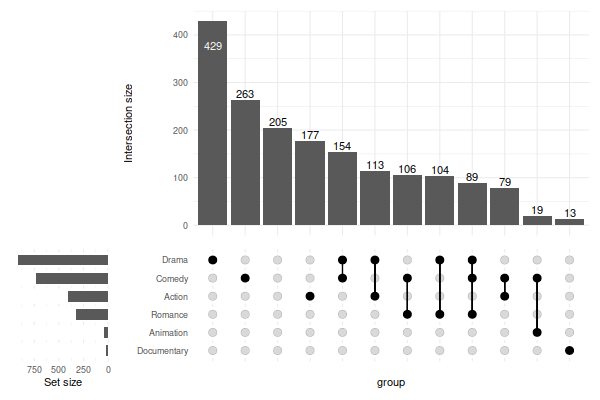

In [43]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes='white'
)

Advanced customization using `upset_stripes()`:

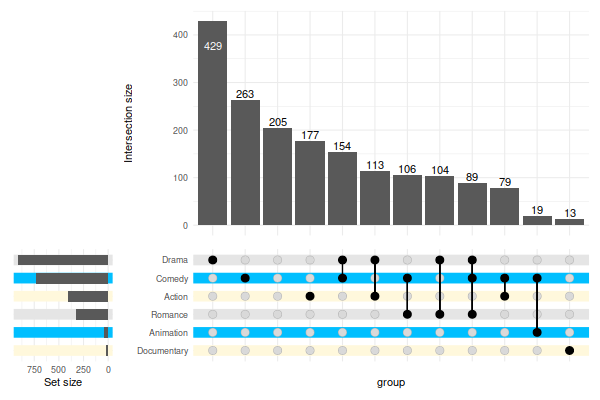

In [44]:
%%R -w 600 -h 400
upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=upset_stripes(
        geom=geom_segment(size=5),
        colors=c('cornsilk1', 'deepskyblue1', 'grey90')
    )
)

Mapping stripes attributes to data using `upset_stripes()`:

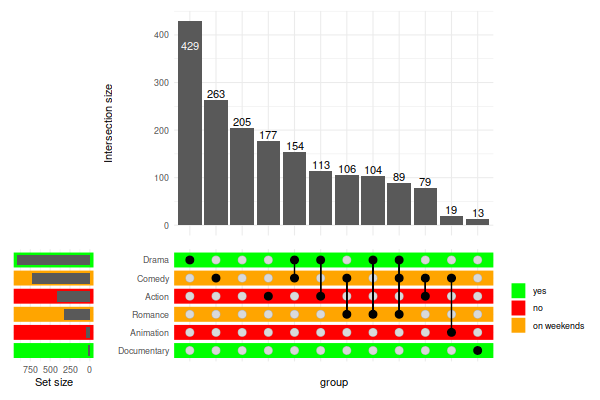

In [45]:
%%R -w 600 -h 400
genre_metadata = data.frame(
    set=c('Action', 'Animation', 'Comedy', 'Drama', 'Documentary', 'Romance', 'Short'),
    shown_in_our_cinema=c('no', 'no', 'on weekends', 'yes', 'yes', 'on weekends', 'no')
)

upset(
    movies,
    genres,
    min_size=10,
    width_ratio=0.2,
    stripes=upset_stripes(
        mapping=aes(color=shown_in_our_cinema),
        colors=c(
            'yes'='green',
            'no'='red',
            'on weekends'='orange'
        ),
        data=genre_metadata
    )
)

### 5.2 Adding title

Adding title with `ggtitle` with add it to the intersection matrix:

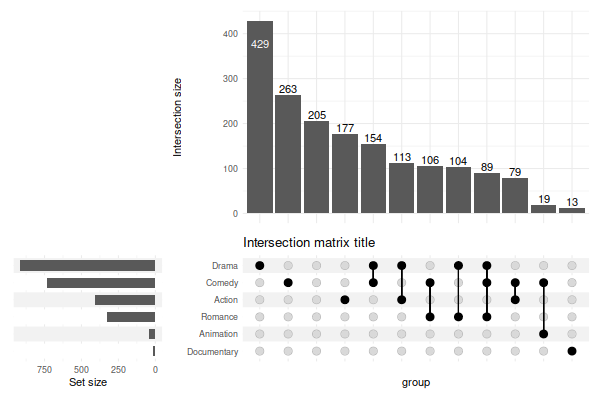

In [46]:
%%R -w 600 -h 400
upset(movies, genres, min_size=10) + ggtitle('Intersection matrix title')

In order to add a title for the entire plot, you need to wrap the plot:

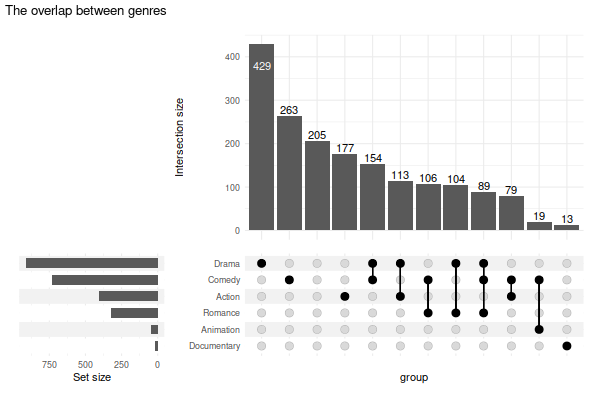

In [47]:
%%R -w 600 -h 400
upset(movies, genres, min_size=10, wrap=TRUE) + ggtitle('The overlap between genres')

### 5.3 Making the plot transparent

You need to set the plot background to transparent and adjust colors of stripes to your liking:

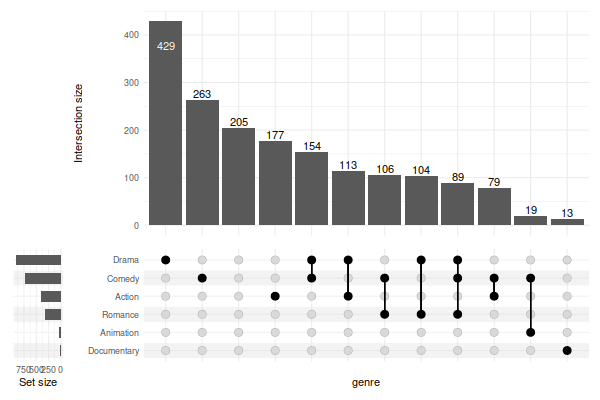

In [48]:
%%R -w 600 -h 400
(
    upset(
        movies, genres, name='genre', width_ratio=0.1, min_size=10,
        stripes=c(alpha('grey90', 0.45), alpha('white', 0.3))
    )
    & theme(plot.background=element_rect(fill='transparent', color=NA))
)

Use `ggsave('upset.png', bg="transparent")` when exporting to PNG.

### 5.4 Adjusting the intersection matrix

Use `intersection_matrix()` to modify the matrix parameters:

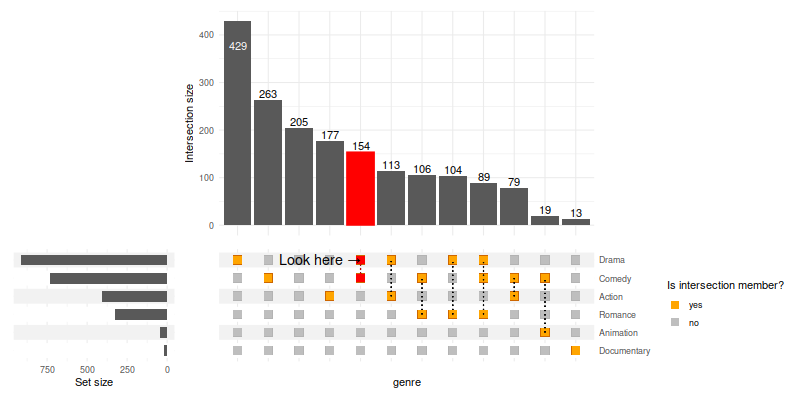

In [51]:
%%R -w 800 -h 400
upset(
    movies, genres, name='genre', min_size=10,
    encode_sets=FALSE,  # for annotate() to select the set by name disable encoding
    matrix=(
        intersection_matrix(
            geom=geom_point(
                shape='square',
                size=3.5
            ),
            segment=geom_segment(
                linetype='dotted'
            ),
            outline_color=list(
                active='darkorange3',
                inactive='grey70'
            )
        )
        + scale_color_manual(
            values=c('TRUE'='orange', 'FALSE'='grey'),
            labels=c('TRUE'='yes', 'FALSE'='no'),
            breaks=c('TRUE', 'FALSE'),
            name='Is intersection member?',
            na.value='transparent'
        )
        + scale_y_discrete(
            position='right'
        )
        + annotate(
            geom='text',
            label='Look here →',
            x='Comedy-Drama',
            y='Drama',
            size=5,
            hjust=1
        )
    ),
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        )
    )
)

You can also enable segment outline to increase contrast:

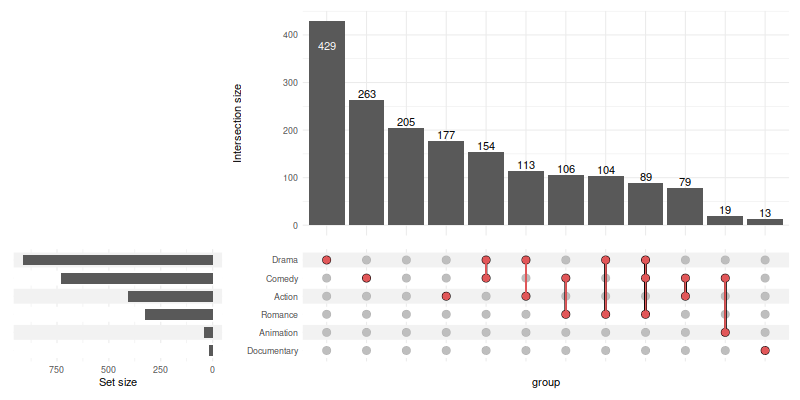

In [50]:
%%R -w 800 -h 400
upset(
    movies, genres, min_size=10,
    matrix=intersection_matrix(
        segment_outline=0.9,
        segment=geom_segment(color='#e15759'),
        outline_color=list(active="black", inactive="grey70"),
    ) + scale_color_manual(
        values=c('TRUE'='#e15759', 'FALSE'='grey'),
        na.value='transparent',
        guide='none'
    )
)

## 6. Themes

The themes for specific components are defined in `upset_themes` list, which contains themes for:

In [47]:
%%R
names(upset_themes)

[1] "intersections_matrix" "Intersection size"    "overall_sizes"       
[4] "default"             


You can substitute this list for your own using `themes` argument. While you can specify a theme for every component, if you omit one or more components those will be taken from the element named `default`.

### 6.1 Substituting themes

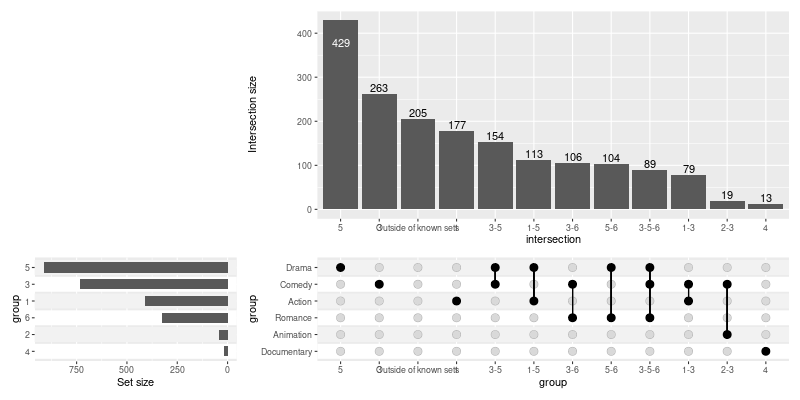

In [48]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, themes=list(default=theme()))

You can also add themes for your custom panels/annotations:

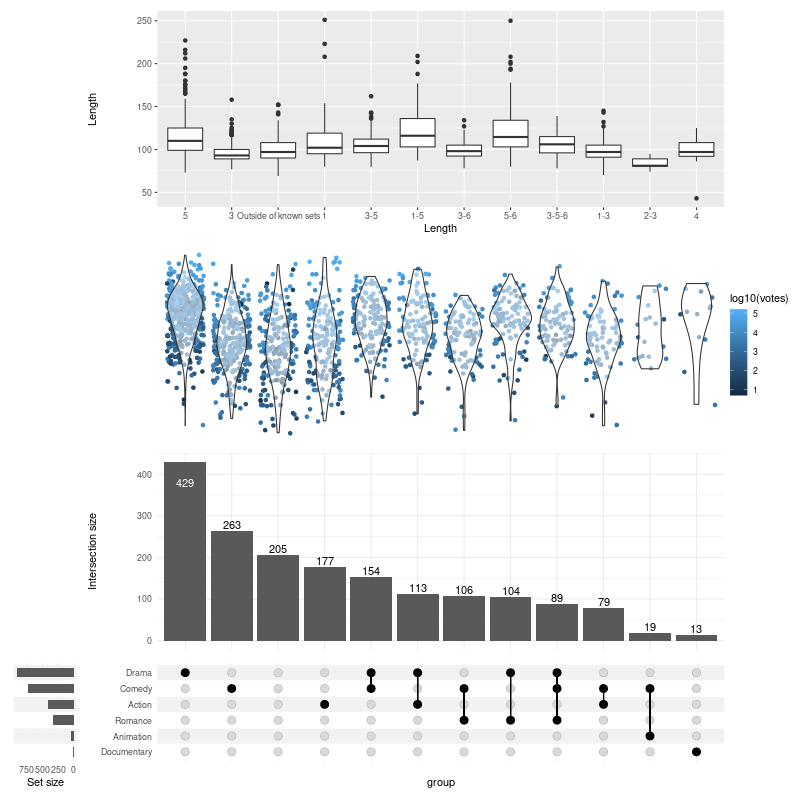

In [49]:
%%R -w 800 -h 800

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot(na.rm=TRUE)
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                geom_jitter(aes(color=log10(votes)), na.rm=TRUE),
                geom_violin(alpha=0.5, na.rm=TRUE)
            )
        )
    ),
    min_size=10,
    width_ratio=0.1,
    themes=modifyList(
        upset_themes,
        list(Rating=theme_void(), Length=theme())
    )
)

### 6.2 Adjusting the default themes

Modify all the default themes as once with `upset_default_themes()`:

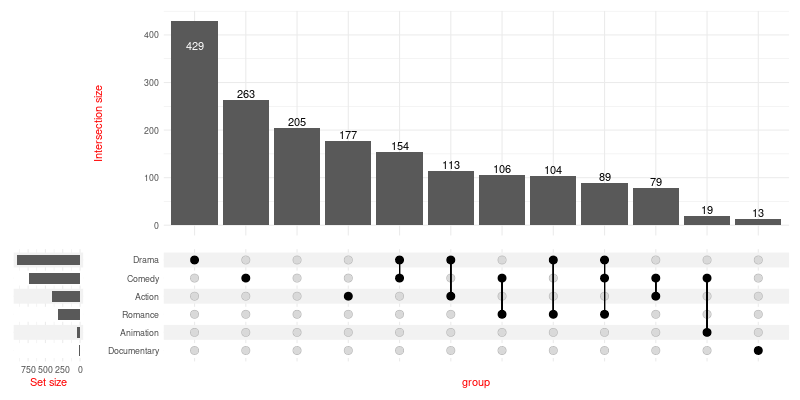

In [50]:
%%R -w 800 -h 400

upset(
    movies, genres, min_size=10, width_ratio=0.1,
    themes=upset_default_themes(text=element_text(color='red'))
)

To modify only a subset of default themes use `upset_modify_themes()`:

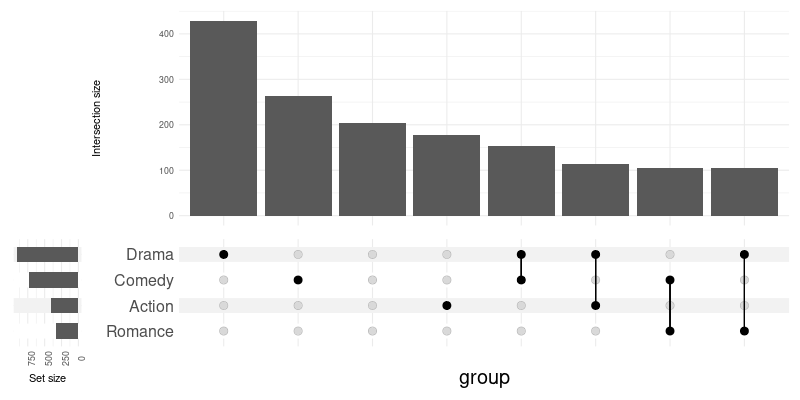

In [51]:
%%R -w 800 -h 400

upset(
    movies, genres,
    base_annotations=list('Intersection size'=intersection_size(counts=FALSE)),
    min_size=100,
    width_ratio=0.1,
    themes=upset_modify_themes(
        list(
            'intersections_matrix'=theme(text=element_text(size=20)),
            'overall_sizes'=theme(axis.text.x=element_text(angle=90))
        )
    )
)

## 7. Highlighting (queries)

Pass a list of lists generated with `upset_query()` utility to the optional `queries` argument to selectively modify aesthetics of specific intersections or sets.

Use one of the arguments: `set` or `intersect` (not both) to specify what to highlight:
- `set` will highlight the bar of the set size,
- `intersect` will highlight an intersection on all components (by default), or on components chosen with `only_components`
- all other parameters will be used to modify the geoms

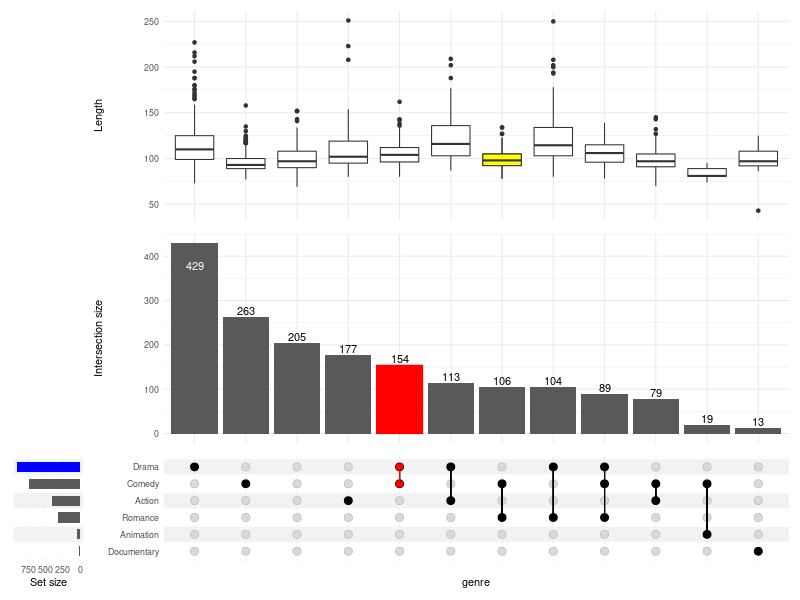

In [52]:
%%R -w 800 -h 600

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot(na.rm=TRUE)
        )
    ),
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        ),
        upset_query(
            set='Drama',
            fill='blue'
        ),
        upset_query(
            intersect=c('Romance', 'Comedy'),
            fill='yellow',
            only_components=c('Length')
        )
    )
)

## 8. Sorting

### 8.1 Sorting intersections

By degree:

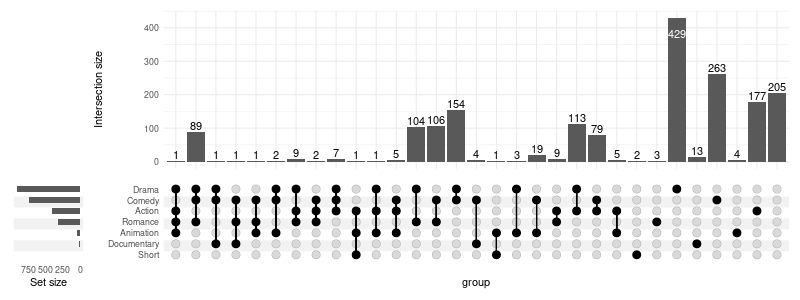

In [53]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections_by='degree')

By ratio:

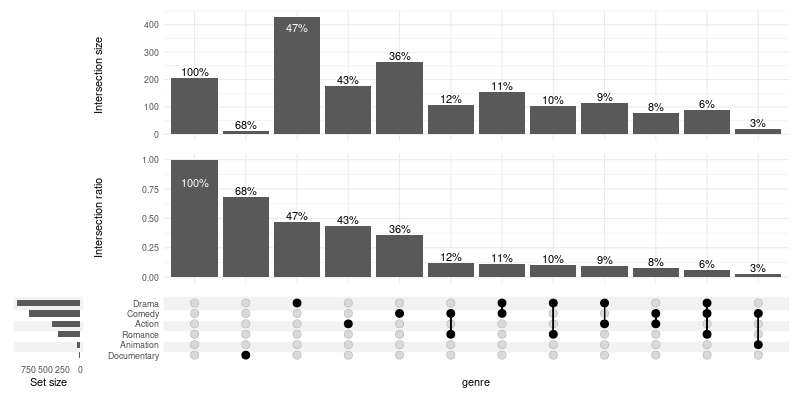

In [54]:
%%R -w 800 -h 400
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    sort_intersections_by='ratio',
    base_annotations=list(
        'Intersection size'=intersection_size(text_mapping=aes(label=!!upset_text_percentage())),
        'Intersection ratio'=intersection_ratio(text_mapping=aes(label=!!upset_text_percentage()))
    )
)

The other way around:

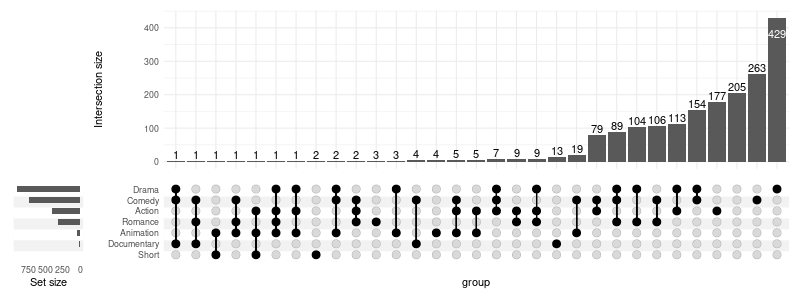

In [55]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections='ascending')

Without any sorting:

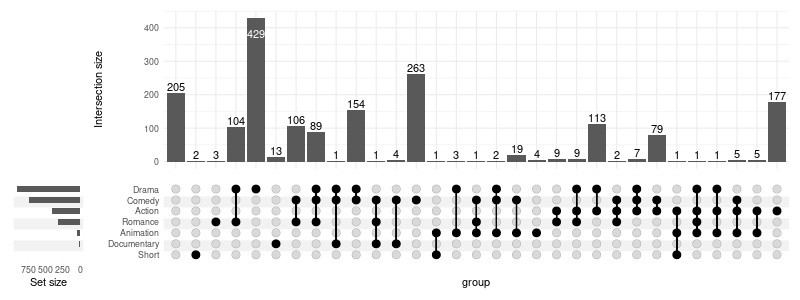

In [56]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections=FALSE)

First by degree then by cardinality:

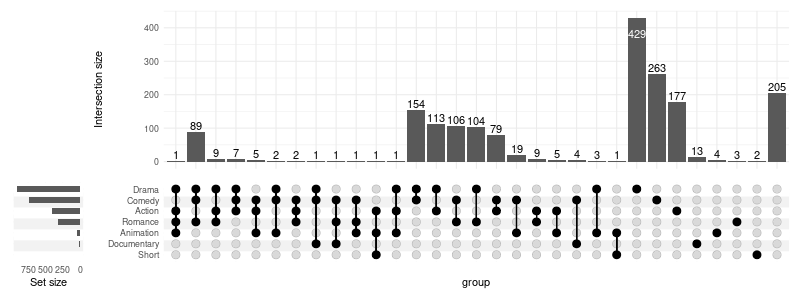

In [57]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_intersections_by=c('degree', 'cardinality'))

User-specified order:

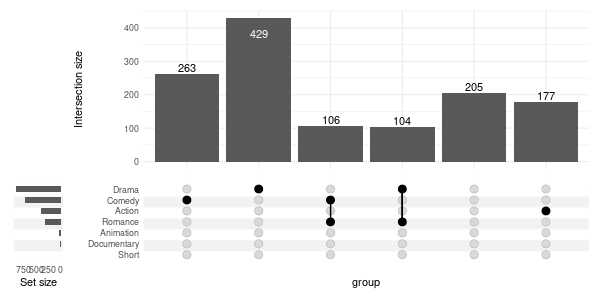

In [58]:
%%R -w 600 -h 300
upset(
    movies,
    genres,
    width_ratio=0.1,
    sort_intersections=FALSE,
    intersections=list(
        'Comedy',
        'Drama',
        c('Comedy', 'Romance'),
        c('Romance', 'Drama'),
        'Outside of known sets',
        'Action'
    )
)

### 8.2 Sorting sets

Ascending:

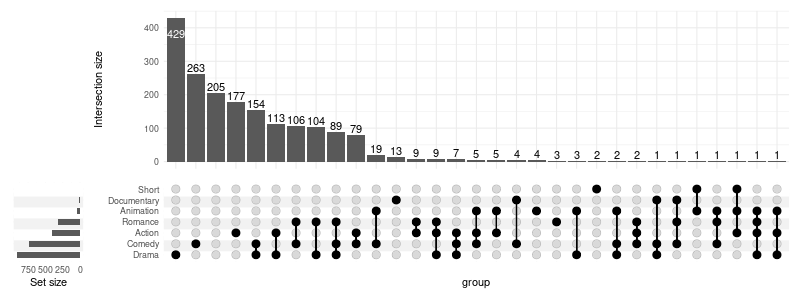

In [59]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_sets='ascending')

Without sorting - preserving the order as in genres:

In [60]:
genres

['Action', 'Animation', 'Comedy', 'Drama', 'Documentary', 'Romance', 'Short']

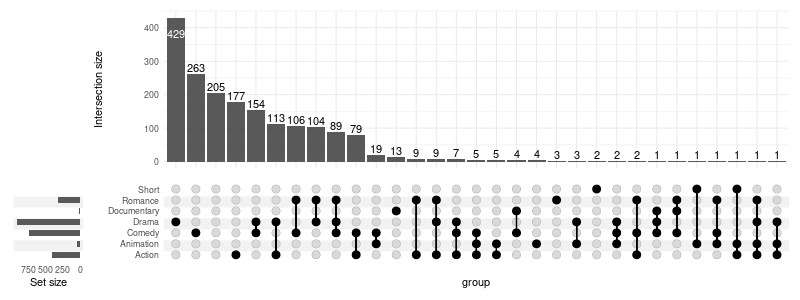

In [61]:
%%R -w 800 -h 300
upset(movies, genres, width_ratio=0.1, sort_sets=FALSE)

## 9. Grouping

### 9.1 Grouping intersections

Use `group_by='sets'` to group intersections by set. If needed, the intersections will be repeated so that they appear in each set group. Use `upset_query()` with `group` argument to color the intersection matrix accordingly.

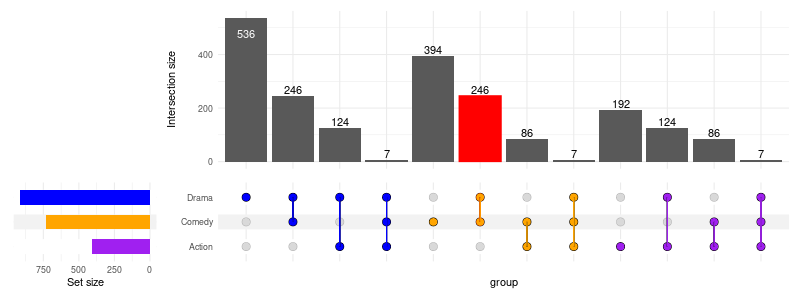

In [62]:
%%R -w 800 -h 300

upset(
    movies, c("Action", "Comedy", "Drama"),
    width_ratio=0.2,
    group_by='sets',
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        ),
        upset_query(group='Drama', color='blue'),
        upset_query(group='Comedy', color='orange'),
        upset_query(group='Action', color='purple'),
        upset_query(set='Drama', fill='blue'),
        upset_query(set='Comedy', fill='orange'),
        upset_query(set='Action', fill='purple')
    )
)

## 10. Display percentages

Use `aes_percentage()` utility preceded with `!!` syntax to easily display percentages. In the examples below only percentages for the movies with R rating are shown to avoid visual clutter.

In [63]:
%%R
rating_scale = scale_fill_manual(values=c(
    'R'='#E41A1C', 'PG'='#377EB8',
    'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
))
show_hide_scale = scale_color_manual(values=c('show'='black', 'hide'='transparent'), guide='none')

### 10.1 Within intersection

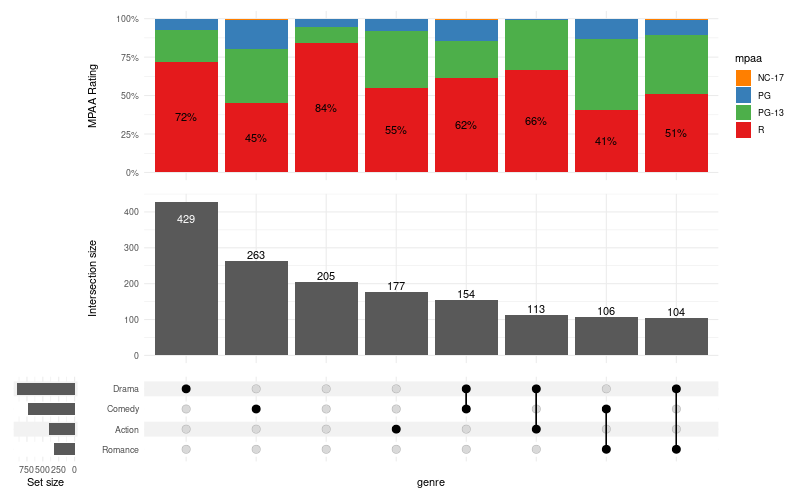

In [64]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Rating'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill', na.rm=TRUE),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='intersection'),
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                rating_scale
            )
        )
    )
)

### 10.2 Relative to the group

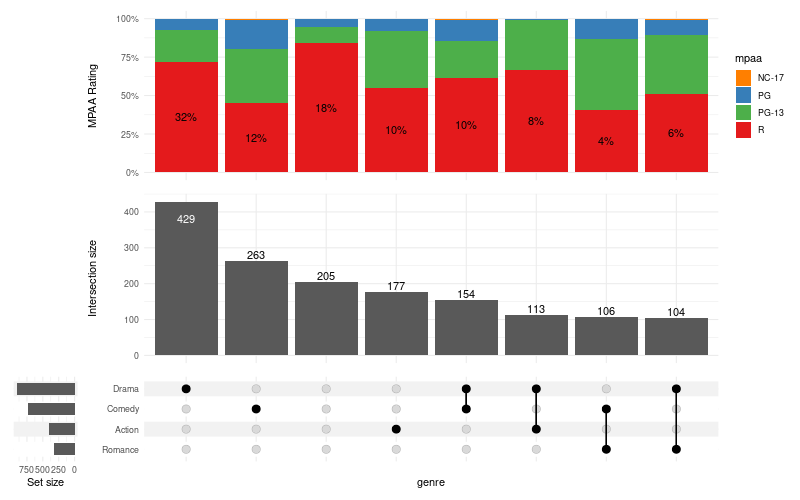

In [65]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Rating'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill', na.rm=TRUE),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='group'),
                        group=mpaa,
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                rating_scale
            )
        )
    )
)


### 10.3 Relative to all observed values

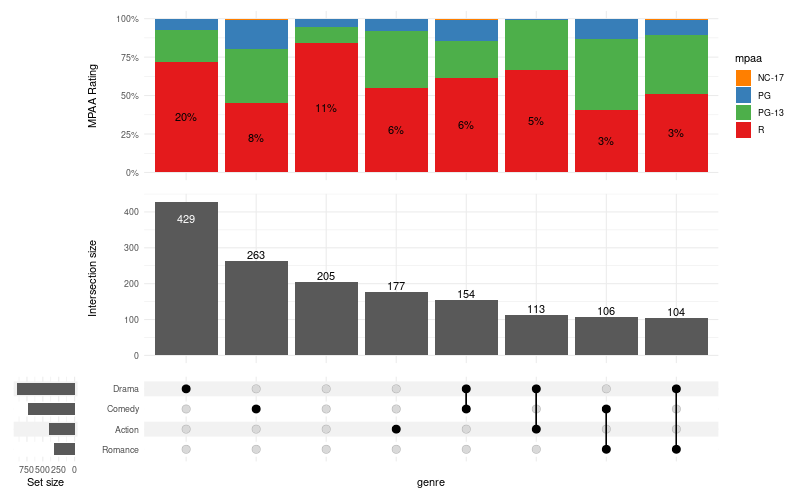

In [66]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Rating'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill', na.rm=TRUE),
                geom_text(
                    aes(
                        label=!!aes_percentage(relative_to='all'),
                        color=ifelse(mpaa == 'R', 'show', 'hide')
                    ),
                    stat='count',
                    position=position_fill(vjust = .5)
                ),
                scale_y_continuous(labels=scales::percent_format()),
                show_hide_scale,
                rating_scale
            )
        )
    )
)

## 11. Advanced usage examples

### 11.1 Display text on some bars only

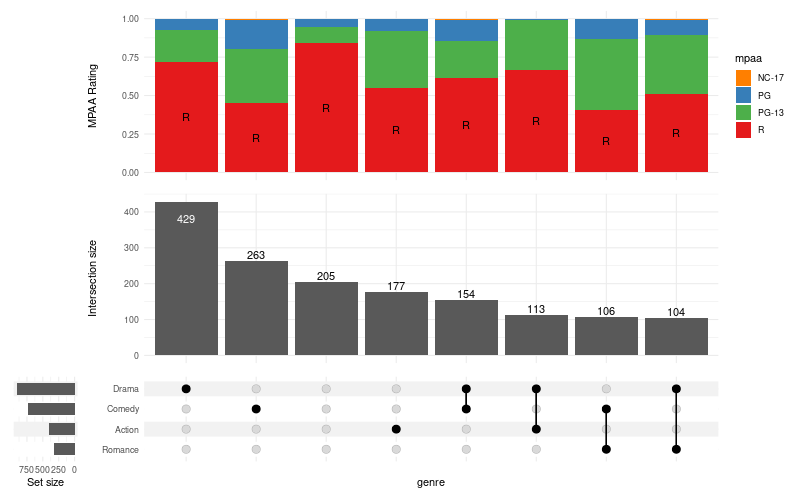

In [67]:
%%R -w 800 -h 500

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Rating'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill', na.rm=TRUE),
                geom_text(
                    aes(label=ifelse(mpaa == 'R', 'R', NA)),
                    stat='count',
                    position=position_fill(vjust = .5),
                    na.rm=TRUE
                ),
                show_hide_scale,
                rating_scale
            )
        )
    )
)

### 11.2 Combine multiple plots together

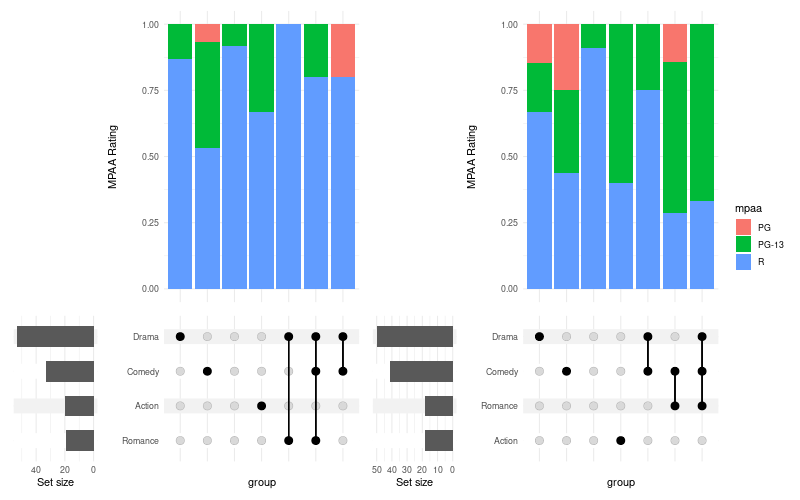

In [68]:
%%R -w 800 -h 500
library(patchwork)

annotations = list(
    'MPAA Rating'=list(
        aes=aes(x=intersection, fill=mpaa),
        geom=list(
            geom_bar(stat='count', position='fill')
        )
    )
)
set.seed(0)    # for replicable example only

data_1 = movies[sample(nrow(movies), 100), ]
data_2 = movies[sample(nrow(movies), 100), ]

u1 = upset(data_1, genres, min_size=5, base_annotations=annotations)
u2 = upset(data_2, genres, min_size=5, base_annotations=annotations)

(u1 | u2) + plot_layout(guides='collect')

### 11.3 Change height of the annotations

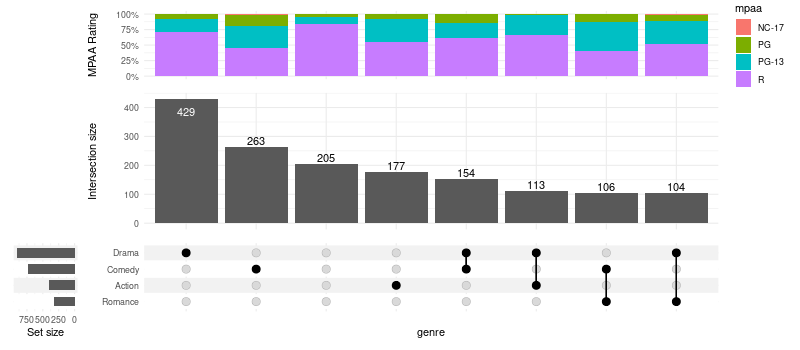

In [69]:
%%R -w 800 -h 350
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=100,
    annotations =list(
        'MPAA Rating'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_y_continuous(labels=scales::percent_format())
            )
        )
    )
) + patchwork::plot_layout(heights=c(0.5, 1, 0.5))

## 12. Venn diagrams

Simple implementation of Venn diagrams is provided, taking the same input format as `upset()` but only supporting up to three sets.

In [70]:
%%R
movies_subset = head(movies, 300)
genres_subset = c('Comedy', 'Drama', 'Action')

movies_subset$good_rating = movies_subset$rating > mean(movies_subset$rating)
arranged = arrange_venn(movies_subset, sets=genres_subset)

### 12.1 Highlight specific elements

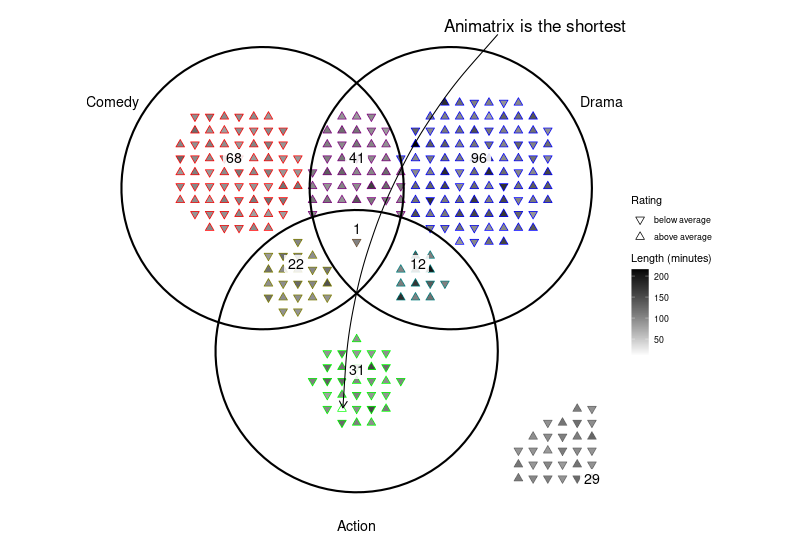

In [71]:
%%R -w 800 -h 550
(
    ggplot(arranged)
    + theme_void()
    + coord_fixed()
    + geom_point(aes(x=x, y=y, color=region, shape=good_rating, fill=length), size=2.7)
    + geom_venn_circle(movies_subset, sets=genres_subset, size=1)
    + geom_venn_label_set(movies_subset, sets=genres_subset, aes(label=region), outwards_adjust=2.6)
    + geom_venn_label_region(movies_subset, sets=genres_subset, aes(label=size), position=position_nudge(y=0.15))
    + geom_curve(
        data=arranged[which.min(arranged$length), ],
        aes(xend=x+0.01, yend=y+0.01), x=1.5, y=2.5, curvature=.2,
        arrow = arrow(length = unit(0.015, "npc"))
    )
    + annotate(
        geom='text', x=1.9, y=2.6, size=6,
        label=paste(substr(arranged[which.min(arranged$length), ]$title, 0, 9), 'is the shortest')
    )
    + scale_color_venn_mix(movies, sets=genres_subset, guide='none')
    + scale_shape_manual(
        values=c(
            'TRUE'='triangle filled',
            'FALSE'='triangle down filled'
        ),
        labels=c(
            'TRUE'='above average',
            'FALSE'='below average'
        ),
        name='Rating'
    )
    + scale_fill_gradient(low='white', high='black', name='Length (minutes)')

)

### 12.2 Highlight all regions

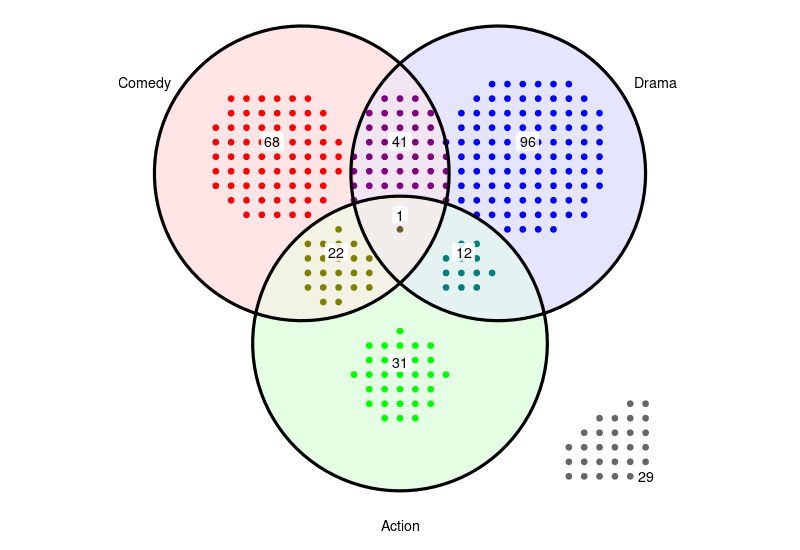

In [72]:
%%R -w 800 -h 550
(
    ggplot(arranged)
    + theme_void()
    + coord_fixed()
    + geom_venn_region(movies_subset, sets=genres_subset, alpha=0.1)
    + geom_point(aes(x=x, y=y, color=region), size=2.5)
    + geom_venn_circle(movies_subset, sets=genres_subset, size=1.5)
    + geom_venn_label_set(movies_subset, sets=genres_subset, aes(label=region), outwards_adjust=2.6)
    + geom_venn_label_region(movies_subset, sets=genres_subset, aes(label=size), position=position_nudge(y=0.15))
    + scale_color_venn_mix(movies, sets=genres_subset, guide='none')
    + scale_fill_venn_mix(movies, sets=genres_subset, guide='none')
)

### 12.3 Highlight specific regions

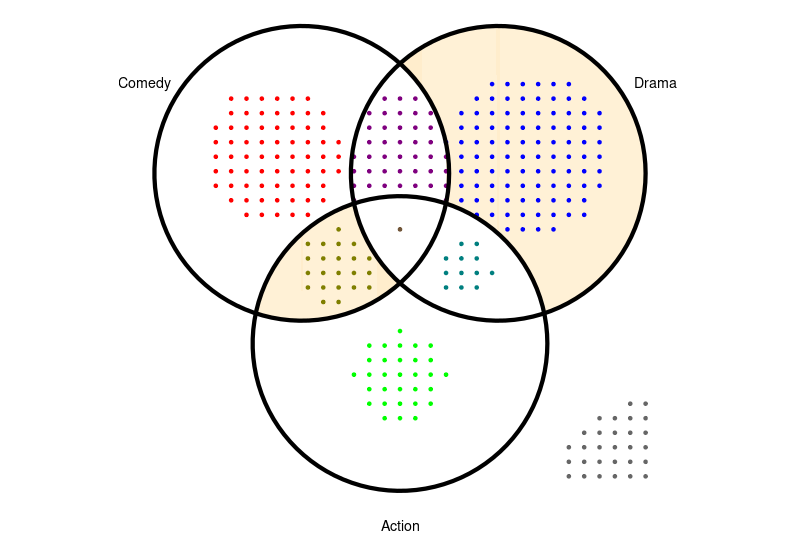

In [73]:
%%R -w 800 -h 550

(
    ggplot(arranged)
    + theme_void()
    + coord_fixed()
    + geom_venn_region(movies_subset, sets=genres_subset, alpha=0.2)
    + geom_point(aes(x=x, y=y, color=region), size=1.5)
    + geom_venn_circle(movies_subset, sets=genres_subset, size=2)
    + geom_venn_label_set(movies_subset, sets=genres_subset, aes(label=region), outwards_adjust=2.6)
    + scale_color_venn_mix(movies, sets=genres_subset, guide='none')
    + scale_fill_venn_mix(movies, sets=genres_subset, guide='none', highlight=c('Comedy-Action', 'Drama'), inactive_color='white')
)

### 12.4 Two sets Venn

The density of the points grid is determined in such a way that the all the points from the set with the largest space restrictions are fit into the available area. In case of the diagram below, its the observations that do not belong to any set that define the grid density:

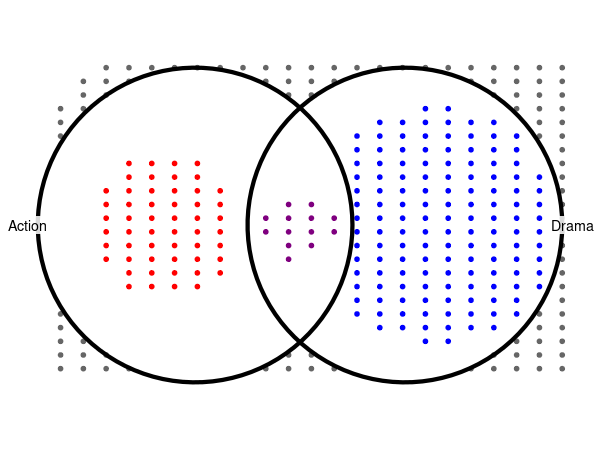

In [74]:
%%R -w 600 -h 450
genres_subset = c('Action', 'Drama')
(
    ggplot(arrange_venn(movies_subset, sets=genres_subset))
    + theme_void()
    + coord_fixed()
    + geom_point(aes(x=x, y=y, color=region), size=2)
    + geom_venn_circle(movies_subset, sets=genres_subset, size=2)
    + geom_venn_label_set(movies_subset, sets=genres_subset, aes(label=region), outwards_adjust=2.6)
    + scale_color_venn_mix(movies, sets=genres_subset, guide='none')
)